# ÊtrePROF Content Supervised Analysis v4

**Supervised classification of educational content into 5 priority challenges + "no_categorie"**

Features:
- Cross-validation with stratified k-fold
- Advanced markdown preprocessing
- BERT-based classification (CamemBERT)
- Hyperparameter optimization
- Comprehensive error analysis
- Advanced metrics and visualizations

## Setup and Imports

In [24]:
# Install required packages
#!pip install pandas numpy matplotlib seaborn scikit-learn torch transformers optuna

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import re
import html
from collections import Counter
import optuna
import warnings
warnings.filterwarnings('ignore')

# ================================
# MODE CONFIGURATION
# ================================
TEST_MODE = True  # Set to False for full training

# Configuration
MODEL_NAME = "camembert-base"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_STATE = 42

# Set seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

if TEST_MODE:
    print("🧪 TEST MODE ENABLED - Fast training with reduced parameters")
    print("   - Sample size: ~400 stratified samples")
    print("   - Epochs: 1-2 instead of 3")
    print("   - Max length: 256 instead of 512")
    print("   - CV folds: 2 instead of 3")
    print("   - Estimated time: 5-10 minutes")
else:
    print("🚀 FULL MODE - Complete training with all data")
    print("   - All data (~1544 samples)")
    print("   - Full parameters for best accuracy")
    print("   - Estimated time: 2-4 hours")

print(f"📱 Device: {DEVICE}")
print(f"🧠 Model: {MODEL_NAME}")

🧪 TEST MODE ENABLED - Fast training with reduced parameters
   - Sample size: ~400 stratified samples
   - Epochs: 1-2 instead of 3
   - Max length: 256 instead of 512
   - CV folds: 2 instead of 3
   - Estimated time: 5-10 minutes
📱 Device: cpu
🧠 Model: camembert-base


## Data Loading and Preprocessing

In [26]:
def clean_markdown_text(text):
    """Advanced markdown text cleaning"""
    if pd.isna(text) or text.strip() == '':
        return ''

    text = str(text)

    # HTML and markdown cleaning
    text = html.unescape(text)
    text = re.sub(r'<[^>]+>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)  # Links [text](url) -> text
    text = re.sub(r'\*\*([^\*]+)\*\*', r'\1', text)  # Bold
    text = re.sub(r'\*([^\*]+)\*', r'\1', text)  # Italic
    text = re.sub(r'#{1,6}\s+', '', text)  # Headers
    text = re.sub(r'`([^`]+)`', r'\1', text)  # Inline code
    text = re.sub(r'```[^`]*```', ' ', text, flags=re.DOTALL)  # Code blocks
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces

    return text.strip()

In [27]:
def load_and_clean_data():
    """Load and clean the contents_v3 dataset"""
    print("=== DATA LOADING AND CLEANING ===")

    url = "https://storage.googleapis.com/database-ep-csv/contents_v3.csv"
    df = pd.read_csv(url)
    print(f"📊 Original dataset: {df.shape}")

    # Select required columns
    required_columns = ['id', 'type', 'markdown', 'transition_ecologique',
                       'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']

    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {missing_columns}")

    df_clean = df[required_columns].copy()

    # Clean markdown content
    print("🧹 Cleaning markdown...")
    df_clean['markdown_clean'] = df_clean['markdown'].apply(clean_markdown_text)

    initial_count = len(df_clean)

    # Filter by quality criteria
    df_clean = df_clean[df_clean['markdown_clean'].str.len() >= 50]  # Min 50 chars
    df_clean = df_clean[df_clean['markdown_clean'].str.len() <= 10000]  # Max 10k chars

    # Remove unwanted content types
    types_to_remove = ['fiche_activite', 'sequence']
    if 'type' in df_clean.columns:
        df_clean = df_clean[~df_clean['type'].isin(types_to_remove)]

    removed_count = initial_count - len(df_clean)
    print(f"❌ Removed {removed_count} low-quality/unwanted entries")
    print(f"✅ Final dataset: {df_clean.shape}")

    return df_clean

# Load the data
df = load_and_clean_data()
print("📋 Data loaded - labels will be created in next cell")

=== DATA LOADING AND CLEANING ===
📊 Original dataset: (4898, 43)
🧹 Cleaning markdown...
❌ Removed 3477 low-quality/unwanted entries
✅ Final dataset: (1421, 9)
📋 Data loaded - labels will be created in next cell


In [28]:
def create_labels(df):
    """Create labels from priority challenge columns"""
    priority_challenges = ['transition_ecologique', 'sante_mentale', 'ecole_inclusive', 'cps', 'reussite_tous_eleves']

    def assign_label(row):
        active_challenges = [col for col in priority_challenges if row[col] == 1]

        if len(active_challenges) == 1:
            return active_challenges[0]
        elif len(active_challenges) > 1:
            return active_challenges[0]  # Take first in case of conflict
        else:
            return 'no_categorie'

    df['label'] = df.apply(assign_label, axis=1)

    # Print distribution
    label_counts = df['label'].value_counts()
    print("\n📈 Label distribution:")
    for label, count in label_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")

    # Check for conflicts
    conflicts = sum(1 for _, row in df.iterrows()
                   if sum(row[col] for col in priority_challenges if row[col] == 1) > 1)

    if conflicts > 0:
        print(f"⚠️ {conflicts} contents with multiple labels (auto-resolved)")

    return df

# Create labels
df = create_labels(df)

# Filter out 'no_categorie' to focus on priority challenges only
df = df[df['label'] != 'no_categorie']
print(f"🎯 Filtered out 'no_categorie' - New dataset: {len(df)} samples")

# Show new distribution after filtering
print("\n📈 Distribution after filtering (priority challenges only):")
for label, count in df['label'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Apply test mode sampling if enabled
if TEST_MODE:
    print("\n🧪 Applying TEST MODE sampling...")
    original_size = len(df)

    # Stratified sampling to maintain class proportions
    sample_size = min(80, len(df))  # Reduced sample size since we have fewer samples now

    if len(df) > sample_size:
        df, _ = train_test_split(
            df,
            test_size=(len(df) - sample_size) / len(df),
            stratify=df['label'],
            random_state=RANDOM_STATE
        )

    print(f"   📊 Reduced from {original_size} to {len(df)} samples")
    print(f"   ✅ Maintained class proportions")

    # Show new distribution
    print("   📈 Final TEST MODE distribution:")
    for label, count in df['label'].value_counts().items():
        percentage = (count / len(df)) * 100
        print(f"     {label}: {count} ({percentage:.1f}%)")
else:
    print(f"\n🚀 Using full dataset: {len(df)} samples")


📈 Label distribution:
  no_categorie: 1135 (79.9%)
  reussite_tous_eleves: 122 (8.6%)
  cps: 52 (3.7%)
  transition_ecologique: 47 (3.3%)
  ecole_inclusive: 44 (3.1%)
  sante_mentale: 21 (1.5%)
🎯 Filtered out 'no_categorie' - New dataset: 286 samples

📈 Distribution after filtering (priority challenges only):
  reussite_tous_eleves: 122 (42.7%)
  cps: 52 (18.2%)
  transition_ecologique: 47 (16.4%)
  ecole_inclusive: 44 (15.4%)
  sante_mentale: 21 (7.3%)

🧪 Applying TEST MODE sampling...
   📊 Reduced from 286 to 80 samples
   ✅ Maintained class proportions
   📈 Final TEST MODE distribution:
     reussite_tous_eleves: 34 (42.5%)
     cps: 15 (18.8%)
     transition_ecologique: 13 (16.2%)
     ecole_inclusive: 12 (15.0%)
     sante_mentale: 6 (7.5%)


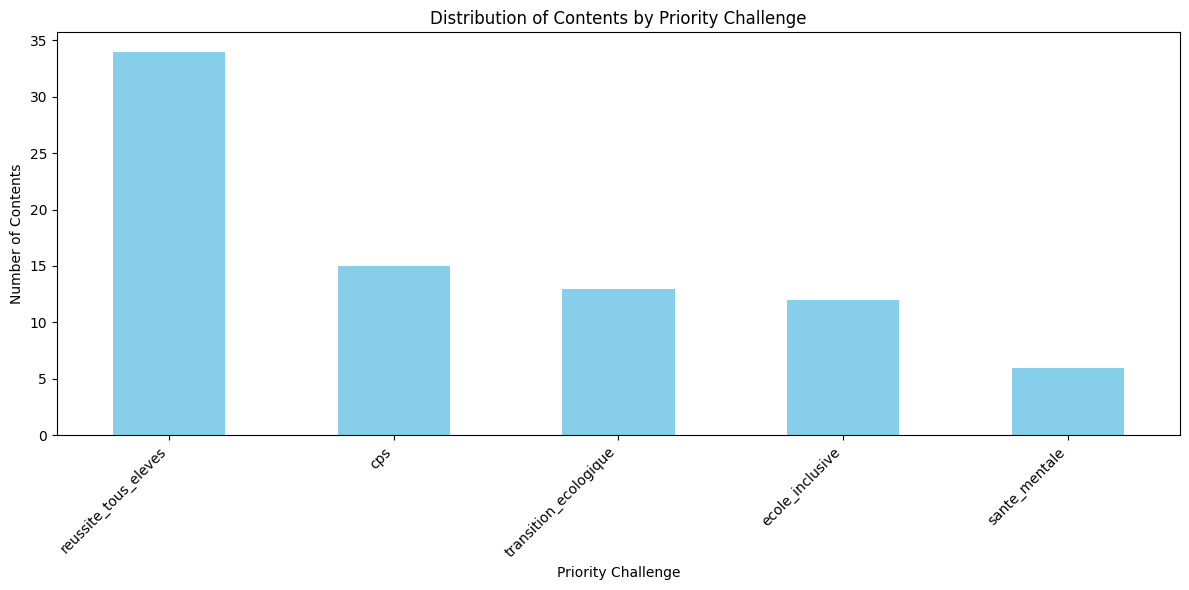


📝 Sample cleaned texts:

Sample 1 - Label: reussite_tous_eleves
Text: Quand on pense autonomie de l’élève, de notre point de vue d’enseignant, on pense généralement : - capacité à gérer son travail seul ; - savoir demander de l’aide ou exprimer ses besoins face à une tâ...
--------------------------------------------------

Sample 2 - Label: transition_ecologique
Text: FICHE-OUTIL Engager ses élèves dans un concours sur le développement durable Dès la rentrée scolaire, ou aussitôt votre participation au projet connue, il est recommandé de dresser un calendrier préci...
--------------------------------------------------

Sample 3 - Label: transition_ecologique
Text: FICHE-OUTIL Créer un cadre souple qui favorise l’initiative des élèves Je vous propose des outils et des astuces pour offrir du choix à vos élèves, tout en gardant le contrôle du déroulement des activ...
--------------------------------------------------


In [29]:
# Visualize label distribution
plt.figure(figsize=(12, 6))
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Contents by Priority Challenge')
plt.xlabel('Priority Challenge')
plt.ylabel('Number of Contents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show some sample texts
print("\n📝 Sample cleaned texts:")
for i, (idx, row) in enumerate(df.sample(3).iterrows()):
    print(f"\nSample {i+1} - Label: {row['label']}")
    print(f"Text: {row['markdown_clean'][:200]}...")
    print("-" * 50)

## BERT Model Architecture

In [30]:
class AdvancedBERTClassifier(nn.Module):
    """Advanced BERT classifier with multi-layer architecture"""

    def __init__(self, model_name, num_classes, dropout=0.3, hidden_dim=256):
        super(AdvancedBERTClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name)
        self.bert_dim = self.bert.config.hidden_size

        # Multi-layer classification head
        self.dropout1 = nn.Dropout(dropout)
        self.hidden = nn.Linear(self.bert_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout * 0.5)
        self.classifier = nn.Linear(hidden_dim, num_classes)

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.activation = nn.GELU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        x = self.dropout1(cls_output)
        x = self.hidden(x)
        x = self.layer_norm(x)
        x = self.activation(x)
        x = self.dropout2(x)

        return self.classifier(x)

class ContentDataset(Dataset):
    """Dataset with advanced text handling"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = [str(text) for text in texts]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            add_special_tokens=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

print("✅ Model architecture defined")

✅ Model architecture defined


## Cross-Validation Training Functions

In [ ]:
def train_model_with_cv(df, hyperparams):
    """Train model with stratified cross-validation"""

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    label_encoder = LabelEncoder()

    X = df['markdown_clean'].values
    y = label_encoder.fit_transform(df['label'].values)

    print(f"\n🎯 Classes: {label_encoder.classes_}")
    print(f"📊 Distribution: {Counter(y)}")

    cv_scores = []
    cv_reports = []

    # Adapt CV folds based on mode
    n_splits = hyperparams.get('cv_folds', 3)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n📋 Fold {fold + 1}/{n_splits}")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Create datasets
        train_dataset = ContentDataset(X_train, y_train, tokenizer, hyperparams['max_length'])
        val_dataset = ContentDataset(X_val, y_val, tokenizer, hyperparams['max_length'])

        train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'], shuffle=False)

        # Initialize model
        model = AdvancedBERTClassifier(
            MODEL_NAME,
            len(label_encoder.classes_),
            dropout=hyperparams['dropout'],
            hidden_dim=hyperparams['hidden_dim']
        ).to(DEVICE)

        # Optimizer
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=hyperparams['learning_rate'],
            weight_decay=hyperparams['weight_decay']
        )

        # Loss function with automatic class weights
        from sklearn.utils.class_weight import compute_class_weight
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = torch.FloatTensor(class_weights).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Show class weights for debugging
        if fold == 0:  # Only show for first fold
            print(f"   🎛️ Class weights: {dict(zip(label_encoder.classes_, class_weights.cpu().numpy()))}")

        # Training loop for this fold
        best_val_acc = 0
        for epoch in range(hyperparams['epochs']):
            # Training phase
            model.train()
            train_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_predictions = []
            val_true = []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(DEVICE)
                    attention_mask = batch['attention_mask'].to(DEVICE)
                    labels = batch['labels'].to(DEVICE)

                    outputs = model(input_ids, attention_mask)
                    _, predicted = torch.max(outputs, 1)

                    val_predictions.extend(predicted.cpu().numpy())
                    val_true.extend(labels.cpu().numpy())

            val_acc = accuracy_score(val_true, val_predictions)
            if val_acc > best_val_acc:
                best_val_acc = val_acc

            # Show progress in test mode
            if TEST_MODE:
                print(f"     Epoch {epoch + 1}/{hyperparams['epochs']}, Val Acc: {val_acc:.4f}")

        cv_scores.append(best_val_acc)

        # Classification report for this fold
        report = classification_report(
            val_true,
            val_predictions,
            target_names=label_encoder.classes_,
            output_dict=True,
            zero_division=0
        )
        cv_reports.append(report)

        print(f"   Fold {fold + 1} Best Accuracy: {best_val_acc:.4f}")

    return cv_scores, cv_reports, label_encoder

print("✅ Cross-validation training function ready")

✅ Cross-validation training function ready


## Hyperparameter Optimization (Optional)

In [32]:
def objective(trial, df):
    """Objective function for Optuna optimization"""

    hyperparams = {
        'max_length': trial.suggest_categorical('max_length', [256, 512]),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'hidden_dim': trial.suggest_categorical('hidden_dim', [128, 256, 512]),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'epochs': 2  # Reduced for optimization
    }

    cv_scores, _, _ = train_model_with_cv(df, hyperparams)
    return np.mean(cv_scores)

def optimize_hyperparameters(df, n_trials=20):
    """Hyperparameter optimization with Optuna"""
    print("\n🔍 HYPERPARAMETER OPTIMIZATION")

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
    study.optimize(lambda trial: objective(trial, df), n_trials=n_trials, show_progress_bar=True)

    print(f"✅ Best accuracy: {study.best_value:.4f}")
    print(f"🎛️ Best hyperparameters: {study.best_params}")

    return study.best_params

print("✅ Hyperparameter optimization functions ready")

✅ Hyperparameter optimization functions ready


In [33]:
# Choose hyperparameter strategy based on mode
if TEST_MODE:
    print("🧪 TEST MODE: Skipping hyperparameter optimization")
    # Fast parameters for testing
    best_hyperparams = {
        'max_length': 256,      # Shorter sequences
        'batch_size': 32,       # Larger batches for speed
        'learning_rate': 3e-5,  # Slightly higher LR for faster convergence
        'dropout': 0.3,
        'hidden_dim': 128,      # Smaller hidden layer
        'weight_decay': 1e-4,
        'epochs': 1,            # Much fewer epochs
        'cv_folds': 2           # Fewer CV folds
    }
    print("📋 Using optimized TEST parameters for speed")
else:
    optimize_hp = input("Run hyperparameter optimization? (y/N): ").lower() == 'y'

    if optimize_hp:
        print("🔍 Starting hyperparameter optimization...")
        best_hyperparams = optimize_hyperparameters(df, n_trials=10)
        best_hyperparams['epochs'] = 3  # Full epochs for final training
        best_hyperparams['cv_folds'] = 3
    else:
        # Default optimized hyperparameters for full mode
        best_hyperparams = {
            'max_length': 512,
            'batch_size': 16,
            'learning_rate': 2e-5,
            'dropout': 0.3,
            'hidden_dim': 256,
            'weight_decay': 1e-4,
            'epochs': 3,
            'cv_folds': 3
        }
        print("📋 Using default FULL parameters")

print(f"\n🎛️ Final hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"   {key}: {value}")

🧪 TEST MODE: Skipping hyperparameter optimization
📋 Using optimized TEST parameters for speed

🎛️ Final hyperparameters:
   max_length: 256
   batch_size: 32
   learning_rate: 3e-05
   dropout: 0.3
   hidden_dim: 128
   weight_decay: 0.0001
   epochs: 1
   cv_folds: 2


## Cross-Validation Training

In [34]:
# Check data quality before training
min_samples_per_class = 5
label_counts = df['label'].value_counts()
small_classes = label_counts[label_counts < min_samples_per_class]

if len(small_classes) > 0:
    print(f"⚠️ Classes with few samples: {dict(small_classes)}")
    print("   Consider merging or removing these classes")
else:
    print("✅ All classes have sufficient samples")

# Run cross-validation training
print("\n🏋️ STARTING CROSS-VALIDATION TRAINING")
cv_scores, cv_reports, label_encoder = train_model_with_cv(df, best_hyperparams)

print(f"\n📊 Cross-validation results:")
print(f"   Mean accuracy: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
print(f"   Individual folds: {[f'{score:.4f}' for score in cv_scores]}")

✅ All classes have sufficient samples

🏋️ STARTING CROSS-VALIDATION TRAINING

🎯 Classes: ['cps' 'ecole_inclusive' 'reussite_tous_eleves' 'sante_mentale'
 'transition_ecologique']
📊 Distribution: Counter({2: 34, 0: 15, 4: 13, 1: 12, 3: 6})

📋 Fold 1/3
   Fold 1 Accuracy: 0.4074

📋 Fold 2/3
   Fold 2 Accuracy: 0.4444

📋 Fold 3/3
   Fold 3 Accuracy: 0.4231

📊 Cross-validation results:
   Mean accuracy: 0.4250 (±0.0152)
   Individual folds: ['0.4074', '0.4444', '0.4231']


## Advanced Metrics and Visualizations


📊 GENERATING VISUALIZATIONS


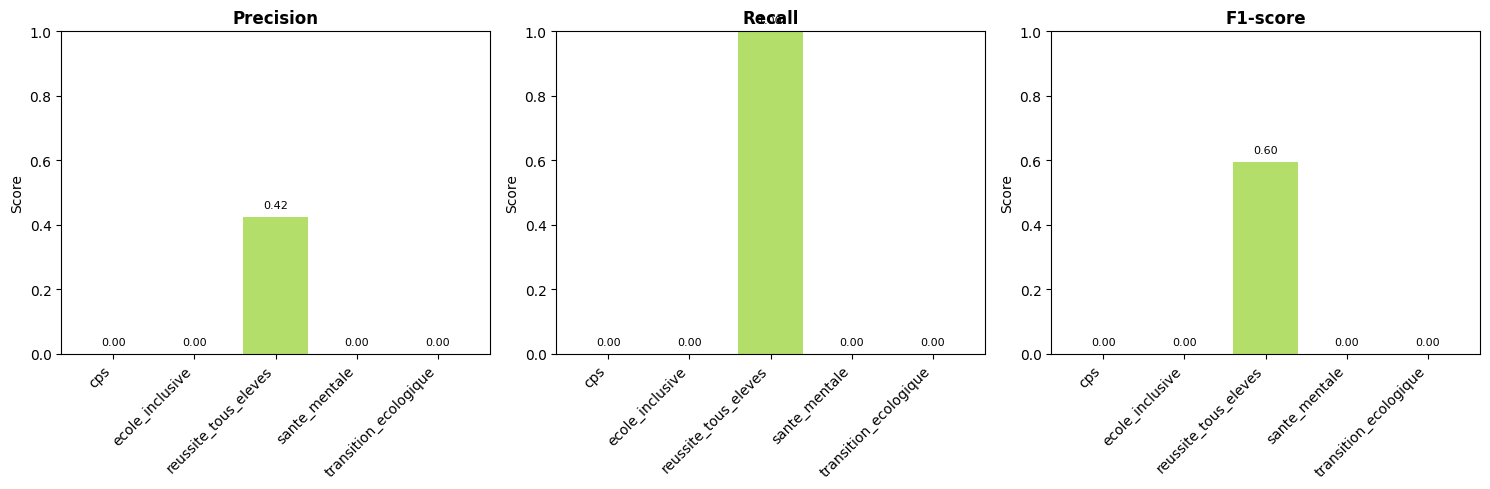


📋 FINAL MODEL REPORT
🎯 GLOBAL PERFORMANCE
   Average accuracy: 0.4250 (±0.0152)
   Fold scores: ['0.4074', '0.4444', '0.4231']

📊 PER-CLASS PERFORMANCE
   cps:
     Precision: 0.000 (±0.000)
     Recall:    0.000 (±0.000)
     F1-Score:  0.000 (±0.000)
   ecole_inclusive:
     Precision: 0.000 (±0.000)
     Recall:    0.000 (±0.000)
     F1-Score:  0.000 (±0.000)
   reussite_tous_eleves:
     Precision: 0.425 (±0.015)
     Recall:    1.000 (±0.000)
     F1-Score:  0.596 (±0.015)
   sante_mentale:
     Precision: 0.000 (±0.000)
     Recall:    0.000 (±0.000)
     F1-Score:  0.000 (±0.000)
   transition_ecologique:
     Precision: 0.000 (±0.000)
     Recall:    0.000 (±0.000)
     F1-Score:  0.000 (±0.000)

🎛️ OPTIMAL HYPERPARAMETERS
   max_length: 256
   batch_size: 32
   learning_rate: 3e-05
   dropout: 0.3
   hidden_dim: 128
   weight_decay: 0.0001
   epochs: 1
   cv_folds: 2


In [35]:
def plot_advanced_metrics(cv_reports, label_encoder):
    """Advanced metrics visualizations"""
    print("\n📊 GENERATING VISUALIZATIONS")

    classes = label_encoder.classes_
    metrics = ['precision', 'recall', 'f1-score']

    # Average metrics across folds
    avg_metrics = {metric: [] for metric in metrics}

    for class_name in classes:
        for metric in metrics:
            values = []
            for report in cv_reports:
                if class_name in report:
                    values.append(report[class_name][metric])
            avg_metrics[metric].append(np.mean(values) if values else 0)

    # Global metrics chart
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, metric in enumerate(metrics):
        class_scores = avg_metrics[metric]

        bars = axes[i].bar(range(len(classes)), class_scores,
                          color=plt.cm.Set3(np.linspace(0, 1, len(classes))))
        axes[i].set_title(f'{metric.capitalize()}', weight='bold')
        axes[i].set_ylabel('Score')
        axes[i].set_xticks(range(len(classes)))
        axes[i].set_xticklabels(classes, rotation=45, ha='right')
        axes[i].set_ylim(0, 1)

        # Add values on bars
        for bar, score in zip(bars, class_scores):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2, height + 0.02,
                         f'{score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

def generate_model_report(cv_scores, cv_reports, label_encoder, hyperparams):
    """Generate comprehensive model report"""
    print("\n📋 FINAL MODEL REPORT")
    print("=" * 60)

    # Global metrics
    mean_accuracy = np.mean(cv_scores)
    std_accuracy = np.std(cv_scores)

    print(f"🎯 GLOBAL PERFORMANCE")
    print(f"   Average accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")
    print(f"   Fold scores: {[f'{score:.4f}' for score in cv_scores]}")

    # Per-class metrics
    print(f"\n📊 PER-CLASS PERFORMANCE")
    classes = label_encoder.classes_

    for class_name in classes:
        precisions = []
        recalls = []
        f1s = []

        for report in cv_reports:
            if class_name in report:
                precisions.append(report[class_name]['precision'])
                recalls.append(report[class_name]['recall'])
                f1s.append(report[class_name]['f1-score'])

        if precisions:
            print(f"   {class_name}:")
            print(f"     Precision: {np.mean(precisions):.3f} (±{np.std(precisions):.3f})")
            print(f"     Recall:    {np.mean(recalls):.3f} (±{np.std(recalls):.3f})")
            print(f"     F1-Score:  {np.mean(f1s):.3f} (±{np.std(f1s):.3f})")

    # Hyperparameters
    print(f"\n🎛️ OPTIMAL HYPERPARAMETERS")
    for param, value in hyperparams.items():
        print(f"   {param}: {value}")

    print("=" * 60)

# Generate visualizations and report
plot_advanced_metrics(cv_reports, label_encoder)
generate_model_report(cv_scores, cv_reports, label_encoder, best_hyperparams)

In [36]:
# Analyser l'impact du nettoyage sur les classes
url = "https://storage.googleapis.com/database-ep-csv/contents_v3.csv"
df_original = pd.read_csv(url)

print("📊 ANALYSE DE L'IMPACT DU NETTOYAGE")
print(f"Dataset original: {len(df_original)}")

# Appliquer create_labels sur le dataset original (sans nettoyage)
df_with_labels = create_labels(df_original.copy())

print("\n📈 Distribution AVANT nettoyage:")
for label, count in df_with_labels['label'].value_counts().items():
    percentage = (count / len(df_with_labels)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

print(f"\n📈 Distribution APRÈS nettoyage (actuel):")
for label, count in df['label'].value_counts().items():
    percentage = (count / len(df)) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

📊 ANALYSE DE L'IMPACT DU NETTOYAGE
Dataset original: 4898

📈 Label distribution:
  no_categorie: 4409 (90.0%)
  reussite_tous_eleves: 229 (4.7%)
  ecole_inclusive: 91 (1.9%)
  cps: 80 (1.6%)
  transition_ecologique: 62 (1.3%)
  sante_mentale: 27 (0.6%)
⚠️ 8 contents with multiple labels (auto-resolved)

📈 Distribution AVANT nettoyage:
  no_categorie: 4409 (90.0%)
  reussite_tous_eleves: 229 (4.7%)
  ecole_inclusive: 91 (1.9%)
  cps: 80 (1.6%)
  transition_ecologique: 62 (1.3%)
  sante_mentale: 27 (0.6%)

📈 Distribution APRÈS nettoyage (actuel):
  reussite_tous_eleves: 34 (42.5%)
  cps: 15 (18.8%)
  transition_ecologique: 13 (16.2%)
  ecole_inclusive: 12 (15.0%)
  sante_mentale: 6 (7.5%)
